In [ ]:
!pip install transformers datasets torch scikit-learn pandas numpy matplotlib seaborn accelerate

In [ ]:
import numpy as np
from huggingface_hub import login
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import KFold
import torch
import warnings
warnings.filterwarnings('ignore')
from google.colab import userdata
hf_token = userdata.get('huggingface')
login(hf_token)

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
dataset = load_dataset("Zlovoblachko/DeepSeek_dim1")

README.md:   0%|          | 0.00/684 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/120k [00:00<?, ?B/s]

data/dev-00000-of-00001.parquet:   0%|          | 0.00/26.5k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1080 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/135 [00:00<?, ? examples/s]

In [ ]:
print("Dataset splits:")
print(dataset)
print("\nSample from training set:")
print(dataset['train'][0])
print("\nColumn names:")
print(dataset['train'].column_names)

Dataset splits:
DatasetDict({
    train: Dataset({
        features: ['Thesis', 'Target sentence segment', 'Last argument', 'Target sentence', 'Dim1_label', '__index_level_0__'],
        num_rows: 1080
    })
    dev: Dataset({
        features: ['Thesis', 'Target sentence segment', 'Last argument', 'Target sentence', 'Dim1_label', '__index_level_0__'],
        num_rows: 135
    })
    test: Dataset({
        features: ['Thesis', 'Target sentence segment', 'Last argument', 'Target sentence', 'Dim1_label', '__index_level_0__'],
        num_rows: 135
    })
})

Sample from training set:
{'Thesis': ' in my opinion it is uself and fun to do pysical exercise and my activity every day. I disagre wits his opinion because these people do not understand that sport should keep fit and mind.', 'Target sentence segment': 'Introductory', 'Last argument': ' Secondly the sport is very fun.', 'Target sentence': 'However some people prefer to watch sports show on tv.', 'Dim1_label': 'L', '__index_level

In [ ]:
train_labels = [item['Dim1_label'] for item in dataset['train']]
val_labels = [item['Dim1_label'] for item in dataset['dev']]
test_labels = [item['Dim1_label'] for item in dataset['test']]

In [ ]:
print(f"Training set - H: {train_labels.count('H')}, L: {train_labels.count('L')}")
print(f"Validation set - H: {val_labels.count('H')}, L: {val_labels.count('L')}")
print(f"Test set - H: {test_labels.count('H')}, L: {test_labels.count('L')}")

Training set - H: 540, L: 540
Validation set - H: 67, L: 68
Test set - H: 68, L: 67


In [ ]:
column_combinations = {
    'target_only': ['Target sentence'],
    'target_last_arg': ['Target sentence', 'Last argument'],
    'target_thesis': ['Target sentence', 'Thesis'],
    'target_segment': ['Target sentence', 'Target sentence segment'],
    'all_columns': ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']
}

In [ ]:
print("Column combinations for ablation study:")
for name, cols in column_combinations.items():
    print(f"{name}: {cols}")

Column combinations for ablation study:
target_only: ['Target sentence']
target_last_arg: ['Target sentence', 'Last argument']
target_thesis: ['Target sentence', 'Thesis']
target_segment: ['Target sentence', 'Target sentence segment']
all_columns: ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']


In [ ]:
def concatenate_columns(example, columns):
    """Concatenate specified columns with [SEP] token"""
    texts = []
    for col in columns:
        if example[col] and str(example[col]).strip():
            texts.append(str(example[col]).strip())
    return ' [SEP] '.join(texts)

In [ ]:
def prepare_dataset(dataset_split, columns, tokenizer, max_length=512):
    """Tokenize and prepare dataset"""
    texts = [concatenate_columns(example, columns) for example in dataset_split]
    labels = [1 if example['Dim1_label'] == 'H' else 0 for example in dataset_split]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels)
    }

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    """PyTorch Dataset wrapper"""
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.encodings['labels'][idx]
        }

    def __len__(self):
        return len(self.encodings['labels'])

In [ ]:
def compute_metrics(pred):
    """Compute evaluation metrics"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
def cross_validate_model(model_name, train_dataset, columns, n_folds=5):
    """Perform k-fold cross-validation and return metrics with CI"""
    print(f"\n{'='*60}")
    print(f"Cross-validating {model_name} with columns: {columns}")
    print(f"{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare data
    texts = [concatenate_columns(example, columns) for example in train_dataset]
    labels = np.array([1 if example['Dim1_label'] == 'H' else 0 for example in train_dataset])

    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    fold_metrics = {
        'accuracy': [],
        'f1': [],
        'precision': [],
        'recall': []
    }

    for fold, (train_idx, val_idx) in enumerate(kfold.split(texts)):
        print(f"\nFold {fold + 1}/{n_folds}")

        # Split data
        train_texts = [texts[i] for i in train_idx]
        train_labels = labels[train_idx]
        val_texts = [texts[i] for i in val_idx]
        val_labels = labels[val_idx]

        # Tokenize
        train_encodings = tokenizer(train_texts, truncation=True, padding='max_length',
                                    max_length=512, return_tensors='pt')
        val_encodings = tokenizer(val_texts, truncation=True, padding='max_length',
                                  max_length=512, return_tensors='pt')

        train_data = TextDataset({
            'input_ids': train_encodings['input_ids'],
            'attention_mask': train_encodings['attention_mask'],
            'labels': torch.tensor(train_labels)
        })

        val_data = TextDataset({
            'input_ids': val_encodings['input_ids'],
            'attention_mask': val_encodings['attention_mask'],
            'labels': torch.tensor(val_labels)
        })

        # Initialize model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2
        )

        # Training arguments
        training_args = TrainingArguments(
            output_dir=f'./results_{model_name.split("/")[-1]}_fold{fold}',
            num_train_epochs=3,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=16,
            learning_rate=2e-5,
            weight_decay=0.01,
            eval_strategy='epoch',
            save_strategy='epoch',
            load_best_model_at_end=True,
            metric_for_best_model='f1',
            logging_dir='./logs',
            logging_steps=10,
            seed=42
        )

        # Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_data,
            eval_dataset=val_data,
            compute_metrics=compute_metrics
        )

        # Train
        trainer.train()

        # Evaluate
        results = trainer.evaluate()

        fold_metrics['accuracy'].append(results['eval_accuracy'])
        fold_metrics['f1'].append(results['eval_f1'])
        fold_metrics['precision'].append(results['eval_precision'])
        fold_metrics['recall'].append(results['eval_recall'])

        print(f"Fold {fold + 1} Results:")
        print(f"  Accuracy: {results['eval_accuracy']:.4f}")
        print(f"  F1: {results['eval_f1']:.4f}")
        print(f"  Precision: {results['eval_precision']:.4f}")
        print(f"  Recall: {results['eval_recall']:.4f}")

    # Calculate statistics
    stats = {}
    for metric, values in fold_metrics.items():
        values_array = np.array(values)
        mean = values_array.mean()
        std = values_array.std()
        # 95% confidence interval
        ci_lower = mean - 1.96 * (std / np.sqrt(n_folds))
        ci_upper = mean + 1.96 * (std / np.sqrt(n_folds))

        stats[metric] = {
            'mean': mean,
            'std': std,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'all_folds': values
        }

    print(f"\n{'='*60}")
    print(f"Cross-Validation Summary for {model_name}")
    print(f"{'='*60}")
    for metric, stat in stats.items():
        print(f"{metric.capitalize()}:")
        print(f"  Mean: {stat['mean']:.4f}")
        print(f"  Std: {stat['std']:.4f}")
        print(f"  95% CI: [{stat['ci_lower']:.4f}, {stat['ci_upper']:.4f}]")

    return stats, fold_metrics

In [ ]:
def train_and_evaluate_best_model(model_name, train_dataset, val_dataset, test_dataset, columns):
    """Train model on full training set and evaluate on test set"""
    print(f"\n{'='*60}")
    print(f"Training {model_name} on full training set")
    print(f"Columns: {columns}")
    print(f"{'='*60}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare datasets
    train_data = prepare_dataset(train_dataset, columns, tokenizer)
    val_data = prepare_dataset(val_dataset, columns, tokenizer)
    test_data = prepare_dataset(test_dataset, columns, tokenizer)

    train_dataset_obj = TextDataset(train_data)
    val_dataset_obj = TextDataset(val_data)
    test_dataset_obj = TextDataset(test_data)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f'./results_{model_name.split("/")[-1]}_best',
        num_train_epochs=5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        logging_dir='./logs',
        logging_steps=10,
        seed=42
    )

    # Trainer with early stopping
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_obj,
        eval_dataset=val_dataset_obj,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Train
    trainer.train()

    # Evaluate on test set
    test_results = trainer.evaluate(test_dataset_obj)

    # Get predictions for detailed analysis
    predictions = trainer.predict(test_dataset_obj)
    pred_labels = predictions.predictions.argmax(-1)
    true_labels = test_data['labels'].numpy()

    print(f"\n{'='*60}")
    print(f"Test Set Results for {model_name}")
    print(f"{'='*60}")
    print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
    print(f"F1: {test_results['eval_f1']:.4f}")
    print(f"Precision: {test_results['eval_precision']:.4f}")
    print(f"Recall: {test_results['eval_recall']:.4f}")

    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(true_labels, pred_labels, target_names=['L', 'H']))

    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    return {
        'test_results': test_results,
        'predictions': pred_labels,
        'true_labels': true_labels,
        'confusion_matrix': cm,
        'model': model,
        'trainer': trainer
    }

In [ ]:
model_names = [
    'bert-base-uncased',
    'roberta-base',
    'answerdotai/ModernBERT-base'
]

In [ ]:
cv_results = {}

In [ ]:
selected_columns = column_combinations['all_columns']

In [ ]:
for model_name in model_names:
    try:
        stats, fold_metrics = cross_validate_model(
            model_name,
            dataset['train'],
            selected_columns,
            n_folds=3
        )
        cv_results[model_name] = {
            'stats': stats,
            'fold_metrics': fold_metrics
        }
    except Exception as e:
        print(f"Error with {model_name}: {str(e)}")
        continue


Cross-validating bert-base-uncased with columns: ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Fold 1/3


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zlovoblachko to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.567600,0.529084,0.766667,0.764567,0.776533,0.766667
2,0.405600,0.397514,0.819444,0.819432,0.819533,0.819444
3,0.270500,0.366482,0.850000,0.849703,0.852787,0.850000


Fold 1 Results:
  Accuracy: 0.8500
  F1: 0.8497
  Precision: 0.8528
  Recall: 0.8500

Fold 2/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.515700,0.599823,0.675000,0.652200,0.761218,0.675000
2,0.400900,0.474334,0.786111,0.785844,0.786175,0.786111
3,0.320100,0.478179,0.788889,0.786625,0.811146,0.788889


Fold 2 Results:
  Accuracy: 0.7889
  F1: 0.7866
  Precision: 0.8111
  Recall: 0.7889

Fold 3/3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.602500,0.499224,0.783333,0.783199,0.783259,0.783333
2,0.524600,0.396278,0.844444,0.844039,0.845528,0.844444
3,0.302700,0.414722,0.833333,0.831322,0.843030,0.833333


Fold 3 Results:
  Accuracy: 0.8444
  F1: 0.8440
  Precision: 0.8455
  Recall: 0.8444

Cross-Validation Summary for bert-base-uncased
Accuracy:
  Mean: 0.8278
  Std: 0.0276
  95% CI: [0.7966, 0.8590]
F1:
  Mean: 0.8268
  Std: 0.0285
  95% CI: [0.7945, 0.8590]
Precision:
  Mean: 0.8365
  Std: 0.0182
  95% CI: [0.8159, 0.8570]
Recall:
  Mean: 0.8278
  Std: 0.0276
  95% CI: [0.7966, 0.8590]

Cross-validating roberta-base with columns: ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Fold 1/3


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.637700,0.576432,0.691667,0.687615,0.702155,0.691667
2,0.467000,0.409117,0.797222,0.796870,0.799301,0.797222
3,0.230300,0.425663,0.827778,0.826573,0.837143,0.827778


Fold 1 Results:
  Accuracy: 0.8278
  F1: 0.8266
  Precision: 0.8371
  Recall: 0.8278

Fold 2/3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.583900,0.564539,0.711111,0.709501,0.722397,0.711111
2,0.411100,0.567764,0.725000,0.720394,0.751552,0.725000
3,0.326800,0.736912,0.752778,0.750272,0.772141,0.752778


Fold 2 Results:
  Accuracy: 0.7528
  F1: 0.7503
  Precision: 0.7721
  Recall: 0.7528

Fold 3/3


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.599600,0.539214,0.761111,0.760491,0.769181,0.761111
2,0.580500,0.437743,0.808333,0.808427,0.809530,0.808333
3,0.319500,0.382169,0.850000,0.849158,0.853669,0.850000


Fold 3 Results:
  Accuracy: 0.8500
  F1: 0.8492
  Precision: 0.8537
  Recall: 0.8500

Cross-Validation Summary for roberta-base
Accuracy:
  Mean: 0.8102
  Std: 0.0416
  95% CI: [0.7631, 0.8573]
F1:
  Mean: 0.8087
  Std: 0.0423
  95% CI: [0.7608, 0.8565]
Precision:
  Mean: 0.8210
  Std: 0.0352
  95% CI: [0.7812, 0.8608]
Recall:
  Mean: 0.8102
  Std: 0.0416
  95% CI: [0.7631, 0.8573]

Cross-validating answerdotai/ModernBERT-base with columns: ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]


Fold 1/3


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W1125 16:19:42.836000 187 torch/_inductor/utils.py:1558] [1/0_1] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.526600,0.497300,0.755556,0.755284,0.756696,0.755556
2,0.473800,0.494661,0.769444,0.764337,0.795022,0.769444
3,0.324600,0.464257,0.822222,0.822200,0.822381,0.822222


Fold 1 Results:
  Accuracy: 0.8222
  F1: 0.8222
  Precision: 0.8224
  Recall: 0.8222

Fold 2/3


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.409600,0.539598,0.730556,0.729771,0.738579,0.730556
2,0.451800,0.558862,0.777778,0.776539,0.791189,0.777778
3,0.195600,0.555636,0.783333,0.783200,0.787922,0.783333


Fold 2 Results:
  Accuracy: 0.7833
  F1: 0.7832
  Precision: 0.7879
  Recall: 0.7833

Fold 3/3


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.568900,0.538635,0.733333,0.725377,0.778601,0.733333


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.568900,0.538635,0.733333,0.725377,0.778601,0.733333
2,0.421700,0.349984,0.852778,0.852713,0.852767,0.852778
3,0.168900,0.352131,0.866667,0.866530,0.866878,0.866667


Fold 3 Results:
  Accuracy: 0.8667
  F1: 0.8665
  Precision: 0.8669
  Recall: 0.8667

Cross-Validation Summary for answerdotai/ModernBERT-base
Accuracy:
  Mean: 0.8241
  Std: 0.0340
  95% CI: [0.7855, 0.8626]
F1:
  Mean: 0.8240
  Std: 0.0340
  95% CI: [0.7855, 0.8625]
Precision:
  Mean: 0.8257
  Std: 0.0323
  95% CI: [0.7892, 0.8623]
Recall:
  Mean: 0.8241
  Std: 0.0340
  95% CI: [0.7855, 0.8626]


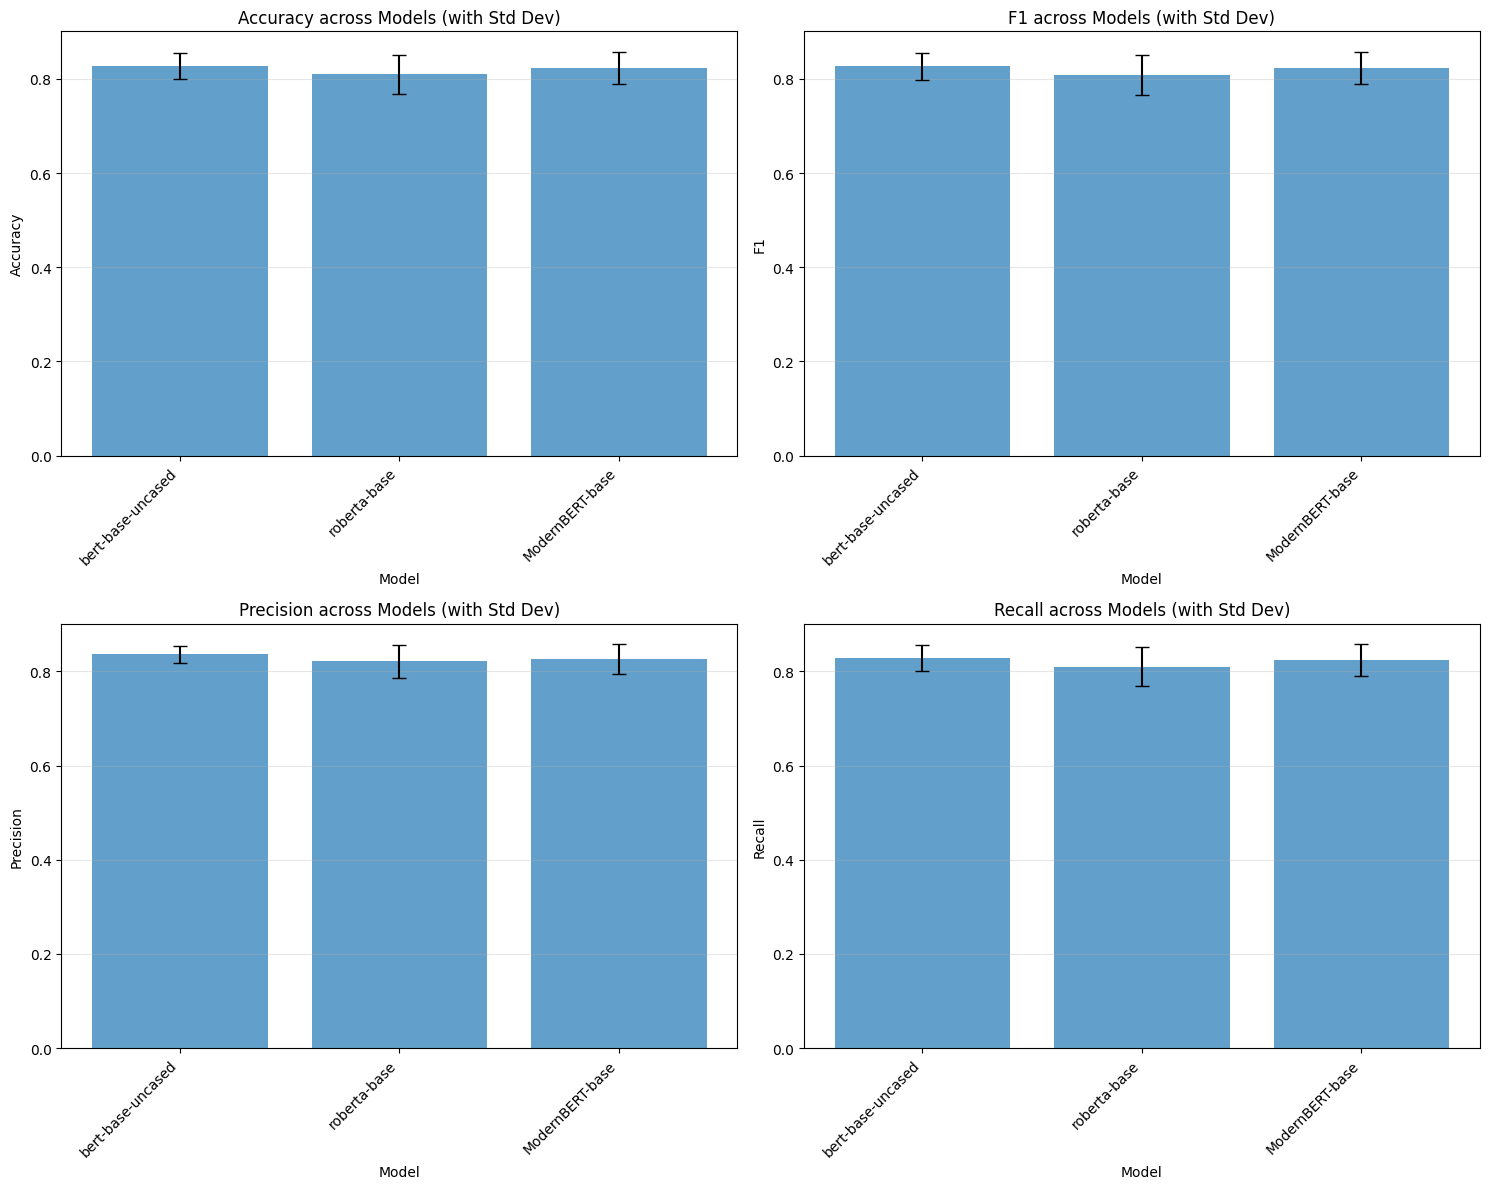

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['accuracy', 'f1', 'precision', 'recall']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]

    model_names_list = list(cv_results.keys())
    means = [cv_results[m]['stats'][metric]['mean'] for m in model_names_list]
    stds = [cv_results[m]['stats'][metric]['std'] for m in model_names_list]

    x_pos = np.arange(len(model_names_list))
    ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} across Models (with Std Dev)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([m.split('/')[-1] for m in model_names_list], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('cv_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
summary_data = []
for model_name, results in cv_results.items():
    for metric in ['accuracy', 'f1', 'precision', 'recall']:
        stats = results['stats'][metric]
        summary_data.append({
            'Model': model_name.split('/')[-1],
            'Metric': metric.capitalize(),
            'Mean': f"{stats['mean']:.4f}",
            'Std': f"{stats['std']:.4f}",
            '95% CI': f"[{stats['ci_lower']:.4f}, {stats['ci_upper']:.4f}]"
        })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY TABLE")
print("="*80)
print(summary_df.to_string(index=False))


CROSS-VALIDATION SUMMARY TABLE
            Model    Metric   Mean    Std           95% CI
bert-base-uncased  Accuracy 0.8278 0.0276 [0.7966, 0.8590]
bert-base-uncased        F1 0.8268 0.0285 [0.7945, 0.8590]
bert-base-uncased Precision 0.8365 0.0182 [0.8159, 0.8570]
bert-base-uncased    Recall 0.8278 0.0276 [0.7966, 0.8590]
     roberta-base  Accuracy 0.8102 0.0416 [0.7631, 0.8573]
     roberta-base        F1 0.8087 0.0423 [0.7608, 0.8565]
     roberta-base Precision 0.8210 0.0352 [0.7812, 0.8608]
     roberta-base    Recall 0.8102 0.0416 [0.7631, 0.8573]
  ModernBERT-base  Accuracy 0.8241 0.0340 [0.7855, 0.8626]
  ModernBERT-base        F1 0.8240 0.0340 [0.7855, 0.8625]
  ModernBERT-base Precision 0.8257 0.0323 [0.7892, 0.8623]
  ModernBERT-base    Recall 0.8241 0.0340 [0.7855, 0.8626]


In [ ]:
best_model_name = max(cv_results.keys(),
                      key=lambda x: cv_results[x]['stats']['f1']['mean'])
print(f"\nBest performing model: {best_model_name}")
print(f"Mean F1 score: {cv_results[best_model_name]['stats']['f1']['mean']:.4f}")


Best performing model: bert-base-uncased
Mean F1 score: 0.8268


In [ ]:
best_model_results = train_and_evaluate_best_model(
    best_model_name,
    dataset['train'],
    dataset['dev'],
    dataset['test'],
    selected_columns
)


Training bert-base-uncased on full training set
Columns: ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.600000,0.566934,0.733333,0.732894,0.735366,0.733333
2,0.448700,0.457823,0.814815,0.811277,0.842201,0.814815
3,0.244000,0.345814,0.888889,0.888767,0.891093,0.888889
4,0.342300,0.346816,0.896296,0.895782,0.905286,0.896296
5,0.146600,0.416360,0.874074,0.872988,0.888628,0.874074



Test Set Results for bert-base-uncased
Accuracy: 0.8444
F1: 0.8443
Precision: 0.8451
Recall: 0.8444

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.86      0.82      0.84        67
           H       0.83      0.87      0.85        68

    accuracy                           0.84       135
   macro avg       0.85      0.84      0.84       135
weighted avg       0.85      0.84      0.84       135



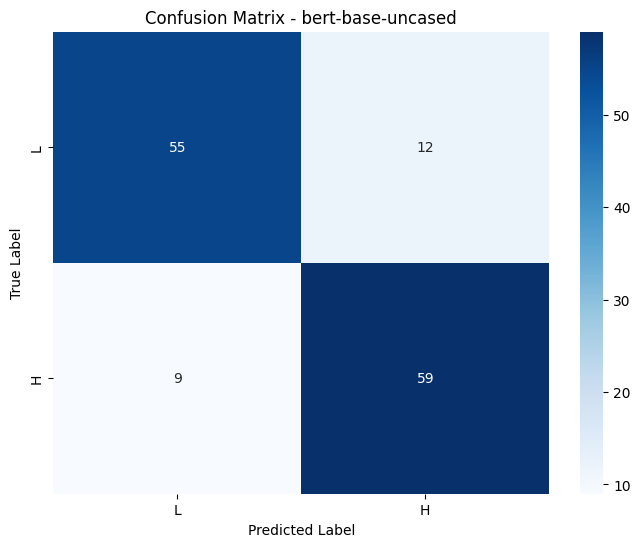

In [ ]:
plt.figure(figsize=(8, 6))
cm = best_model_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['L', 'H'], yticklabels=['L', 'H'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix - {best_model_name.split("/")[-1]}')
plt.savefig('confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n" + "="*80)
print("ABLATION STUDY: COLUMN COMBINATIONS")
print("="*80)

ablation_results = {}

for combo_name, columns in column_combinations.items():
    print(f"\nTesting combination: {combo_name}")
    print(f"Columns: {columns}")

    try:
        results = train_and_evaluate_best_model(
            best_model_name,
            dataset['train'],
            dataset['dev'],
            dataset['test'],
            columns
        )

        ablation_results[combo_name] = {
            'columns': columns,
            'accuracy': results['test_results']['eval_accuracy'],
            'f1': results['test_results']['eval_f1'],
            'precision': results['test_results']['eval_precision'],
            'recall': results['test_results']['eval_recall']
        }
    except Exception as e:
        print(f"Error with {combo_name}: {str(e)}")
        continue


ABLATION STUDY: COLUMN COMBINATIONS

Testing combination: target_only
Columns: ['Target sentence']

Training bert-base-uncased on full training set
Columns: ['Target sentence']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.658800,0.604182,0.674074,0.672781,0.676268,0.674074


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.658800,0.604182,0.674074,0.672781,0.676268,0.674074
2,0.557400,0.663151,0.651852,0.645901,0.661481,0.651852
3,0.298800,0.848106,0.644444,0.641852,0.649628,0.644444



Test Set Results for bert-base-uncased
Accuracy: 0.6222
F1: 0.6133
Precision: 0.6362
Recall: 0.6222

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.59      0.78      0.67        67
           H       0.68      0.47      0.56        68

    accuracy                           0.62       135
   macro avg       0.64      0.62      0.61       135
weighted avg       0.64      0.62      0.61       135


Testing combination: target_last_arg
Columns: ['Target sentence', 'Last argument']

Training bert-base-uncased on full training set
Columns: ['Target sentence', 'Last argument']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.544300,0.504817,0.785185,0.785185,0.785271,0.785185
2,0.453500,0.449458,0.822222,0.822222,0.822222,0.822222
3,0.274700,0.608804,0.792593,0.792251,0.795057,0.792593
4,0.281000,0.653253,0.807407,0.807407,0.807407,0.807407



Test Set Results for bert-base-uncased
Accuracy: 0.8074
F1: 0.8068
Precision: 0.8120
Recall: 0.8074

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.77      0.87      0.82        67
           H       0.85      0.75      0.80        68

    accuracy                           0.81       135
   macro avg       0.81      0.81      0.81       135
weighted avg       0.81      0.81      0.81       135


Testing combination: target_thesis
Columns: ['Target sentence', 'Thesis']

Training bert-base-uncased on full training set
Columns: ['Target sentence', 'Thesis']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.509100,0.465761,0.777778,0.776428,0.783776,0.777778
2,0.343600,0.325593,0.896296,0.895540,0.909336,0.896296
3,0.254600,0.339085,0.896296,0.896125,0.899517,0.896296
4,0.168200,0.441063,0.888889,0.888877,0.888962,0.888889
5,0.077700,0.445903,0.881481,0.881403,0.882877,0.881481



Test Set Results for bert-base-uncased
Accuracy: 0.8370
F1: 0.8364
Precision: 0.8417
Recall: 0.8370

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.88      0.78      0.83        67
           H       0.80      0.90      0.85        68

    accuracy                           0.84       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.84      0.84      0.84       135


Testing combination: target_segment
Columns: ['Target sentence', 'Target sentence segment']

Training bert-base-uncased on full training set
Columns: ['Target sentence', 'Target sentence segment']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.654500,0.563607,0.681481,0.674691,0.696445,0.681481
2,0.430200,0.547521,0.718519,0.717868,0.720074,0.718519
3,0.250600,0.739803,0.740741,0.740313,0.741927,0.740741
4,0.162400,0.876883,0.748148,0.747871,0.748912,0.748148
5,0.044100,1.015014,0.740741,0.740570,0.741132,0.740741



Test Set Results for bert-base-uncased
Accuracy: 0.7333
F1: 0.7330
Precision: 0.7340
Recall: 0.7333

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.75      0.70      0.72        67
           H       0.72      0.76      0.74        68

    accuracy                           0.73       135
   macro avg       0.73      0.73      0.73       135
weighted avg       0.73      0.73      0.73       135


Testing combination: all_columns
Columns: ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']

Training bert-base-uncased on full training set
Columns: ['Target sentence', 'Last argument', 'Thesis', 'Target sentence segment']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.529100,0.507824,0.777778,0.777411,0.780135,0.777778
2,0.445900,0.451972,0.837037,0.834257,0.863076,0.837037
3,0.233500,0.390501,0.881481,0.880894,0.890156,0.881481
4,0.395400,0.471832,0.859259,0.858045,0.873266,0.859259
5,0.074700,0.492868,0.866667,0.865695,0.878782,0.866667



Test Set Results for bert-base-uncased
Accuracy: 0.8370
F1: 0.8364
Precision: 0.8417
Recall: 0.8370

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.88      0.78      0.83        67
           H       0.80      0.90      0.85        68

    accuracy                           0.84       135
   macro avg       0.84      0.84      0.84       135
weighted avg       0.84      0.84      0.84       135



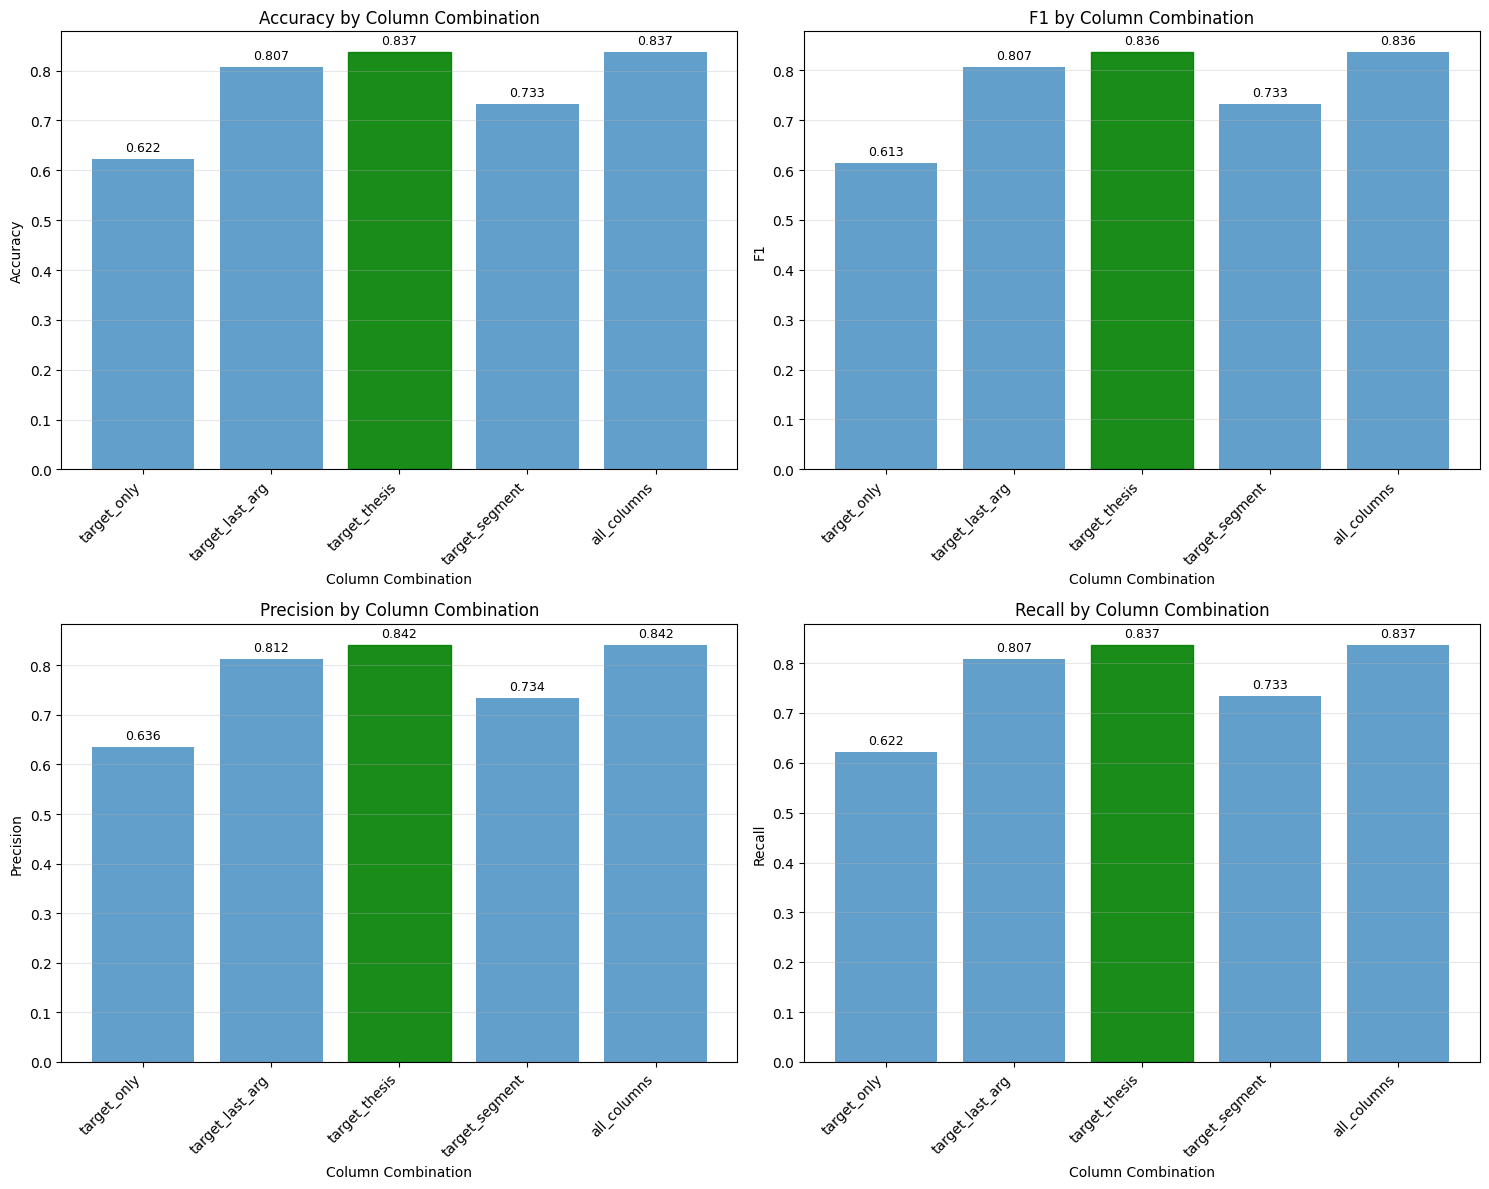

In [ ]:
ablation_df = pd.DataFrame(ablation_results).T
ablation_df = ablation_df.reset_index().rename(columns={'index': 'combination'})

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics_plot = ['accuracy', 'f1', 'precision', 'recall']

for idx, metric in enumerate(metrics_plot):
    ax = axes[idx // 2, idx % 2]

    x_pos = np.arange(len(ablation_df))
    values = ablation_df[metric].values

    bars = ax.bar(x_pos, values, alpha=0.7)

    # Color the bar with highest value
    max_idx = values.argmax()
    bars[max_idx].set_color('green')
    bars[max_idx].set_alpha(0.9)

    ax.set_xlabel('Column Combination')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by Column Combination')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(ablation_df['combination'], rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('ablation_column_combinations.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY: COLUMN COMBINATIONS")
print("="*80)
print(ablation_df.to_string(index=False))

# Find best combination for each metric
print("\nBest combinations per metric:")
for metric in metrics_plot:
    best_combo = ablation_df.loc[ablation_df[metric].idxmax(), 'combination']
    best_value = ablation_df[metric].max()
    print(f"{metric.capitalize()}: {best_combo} ({best_value:.4f})")


ABLATION STUDY SUMMARY: COLUMN COMBINATIONS
    combination                                                           columns  accuracy        f1 precision    recall
    target_only                                                 [Target sentence]  0.622222  0.613321  0.636213  0.622222
target_last_arg                                  [Target sentence, Last argument]  0.807407  0.806814  0.811951  0.807407
  target_thesis                                         [Target sentence, Thesis]  0.837037   0.83639  0.841702  0.837037
 target_segment                        [Target sentence, Target sentence segment]  0.733333   0.73304  0.734039  0.733333
    all_columns [Target sentence, Last argument, Thesis, Target sentence segment]  0.837037   0.83639  0.841702  0.837037

Best combinations per metric:
Accuracy: target_thesis (0.8370)
F1: target_thesis (0.8364)
Precision: target_thesis (0.8417)
Recall: target_thesis (0.8370)


In [ ]:
print("\n" + "="*80)
print("ABLATION STUDY: LAYER FREEZING")
print("="*80)

def train_with_frozen_layers(model_name, train_dataset, val_dataset, test_dataset,
                             columns, n_layers_to_freeze=0):
    """Train model with specified number of frozen layers"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Prepare datasets
    train_data = prepare_dataset(train_dataset, columns, tokenizer)
    val_data = prepare_dataset(val_dataset, columns, tokenizer)
    test_data = prepare_dataset(test_dataset, columns, tokenizer)

    train_dataset_obj = TextDataset(train_data)
    val_dataset_obj = TextDataset(val_data)
    test_dataset_obj = TextDataset(test_data)

    # Initialize model
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    )

    # Freeze layers
    if n_layers_to_freeze > 0:
        # For BERT/RoBERTa, encoder layers are in model.bert.encoder.layer or model.roberta.encoder.layer
        encoder_attr = 'bert' if 'bert' in model_name else 'roberta'
        if hasattr(model, encoder_attr):
            encoder = getattr(model, encoder_attr)
            for i in range(n_layers_to_freeze):
                for param in encoder.encoder.layer[i].parameters():
                    param.requires_grad = False
            print(f"Frozen first {n_layers_to_freeze} layers")

    # Training arguments (fewer epochs for ablation)
    training_args = TrainingArguments(
        output_dir=f'./results_frozen_{n_layers_to_freeze}',
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        logging_dir='./logs',
        logging_steps=10,
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_obj,
        eval_dataset=val_dataset_obj,
        compute_metrics=compute_metrics
    )

    trainer.train()
    test_results = trainer.evaluate(test_dataset_obj)

    return test_results


ABLATION STUDY: LAYER FREEZING


In [ ]:
freeze_configs = [0, 3, 6]  # Number of layers to freeze
freezing_results = {}

In [ ]:
for n_freeze in freeze_configs:
    print(f"\nTesting with {n_freeze} frozen layers...")
    try:
        results = train_with_frozen_layers(
            best_model_name,
            dataset['train'],
            dataset['dev'],
            dataset['test'],
            selected_columns,
            n_freeze
        )

        freezing_results[n_freeze] = {
            'accuracy': results['eval_accuracy'],
            'f1': results['eval_f1'],
            'precision': results['eval_precision'],
            'recall': results['eval_recall']
        }

        print(f"Results with {n_freeze} frozen layers:")
        print(f"  Accuracy: {results['eval_accuracy']:.4f}")
        print(f"  F1: {results['eval_f1']:.4f}")
    except Exception as e:
        print(f"Error with {n_freeze} frozen layers: {str(e)}")
        continue


Testing with 0 frozen layers...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.626500,0.468863,0.792593,0.792570,0.792895,0.792593
2,0.456400,0.490457,0.800000,0.796179,0.826151,0.800000
3,0.197400,0.414081,0.844444,0.843102,0.857904,0.844444


Results with 0 frozen layers:
  Accuracy: 0.8074
  F1: 0.8066

Testing with 3 frozen layers...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen first 3 layers


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.716600,0.553125,0.688889,0.681541,0.706404,0.688889
2,0.413000,0.431675,0.807407,0.803311,0.837314,0.807407
3,0.241000,0.323616,0.874074,0.873310,0.884410,0.874074


Results with 3 frozen layers:
  Accuracy: 0.8444
  F1: 0.8442

Testing with 6 frozen layers...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen first 6 layers


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.654300,0.537041,0.740741,0.739713,0.745350,0.740741
2,0.450800,0.480550,0.777778,0.773051,0.804917,0.777778
3,0.246100,0.398584,0.829630,0.827051,0.852205,0.829630


Results with 6 frozen layers:
  Accuracy: 0.8296
  F1: 0.8284


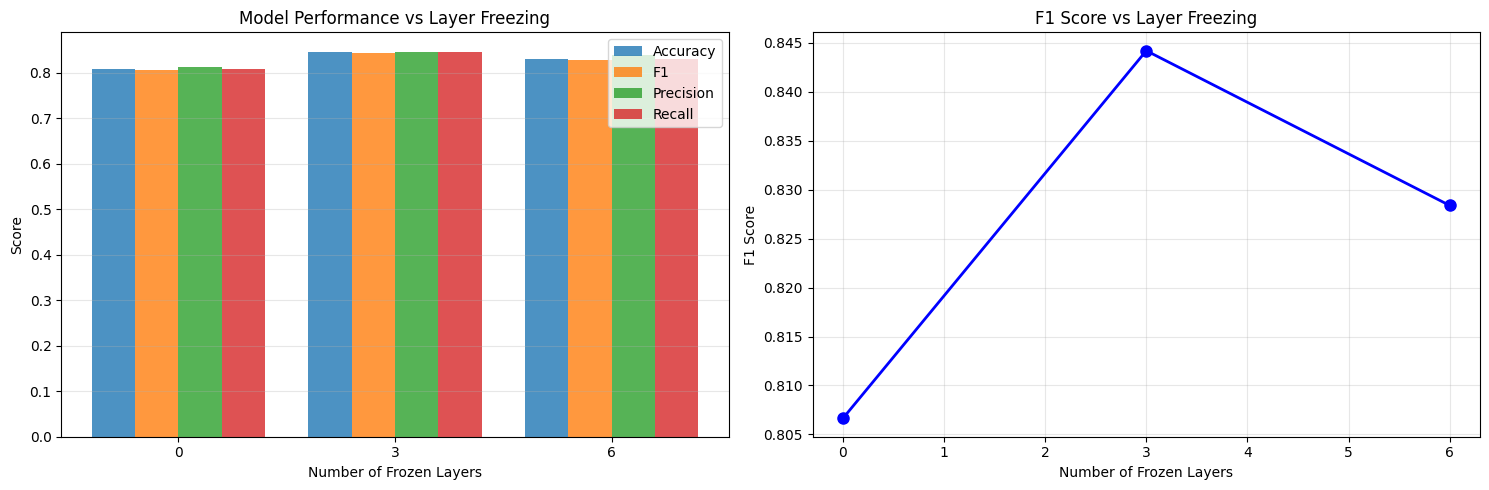

In [ ]:
freezing_df = pd.DataFrame(freezing_results).T
freezing_df = freezing_df.reset_index().rename(columns={'index': 'frozen_layers'})
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: All metrics
ax1 = axes[0]
x_pos = np.arange(len(freezing_df))
width = 0.2

for i, metric in enumerate(['accuracy', 'f1', 'precision', 'recall']):
    ax1.bar(x_pos + i * width, freezing_df[metric], width,
            label=metric.capitalize(), alpha=0.8)

ax1.set_xlabel('Number of Frozen Layers')
ax1.set_ylabel('Score')
ax1.set_title('Model Performance vs Layer Freezing')
ax1.set_xticks(x_pos + width * 1.5)
ax1.set_xticklabels(freezing_df['frozen_layers'].astype(int))
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: F1 score focus
ax2 = axes[1]
ax2.plot(freezing_df['frozen_layers'], freezing_df['f1'], marker='o',
         linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Number of Frozen Layers')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score vs Layer Freezing')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_layer_freezing.png', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
# Cell 22: Print layer freezing summary
print("\n" + "="*80)
print("ABLATION STUDY SUMMARY: LAYER FREEZING")
print("="*80)
print(freezing_df.to_string(index=False))

print("\nBest configuration:")
best_freeze = freezing_df.loc[freezing_df['f1'].idxmax(), 'frozen_layers']
best_f1 = freezing_df['f1'].max()
print(f"Frozen layers: {int(best_freeze)}, F1 score: {best_f1:.4f}")


ABLATION STUDY SUMMARY: LAYER FREEZING
 frozen_layers  accuracy       f1  precision   recall
             0  0.807407 0.806643   0.811623 0.807407
             3  0.844444 0.844188   0.846261 0.844444
             6  0.829630 0.828386   0.838433 0.829630

Best configuration:
Frozen layers: 3, F1 score: 0.8442


In [ ]:
print("\n" + "="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n1. BEST MODEL (from cross-validation):")
print(f"   Model: {best_model_name}")
print(f"   Mean F1: {cv_results[best_model_name]['stats']['f1']['mean']:.4f}")
print(f"   Std: {cv_results[best_model_name]['stats']['f1']['std']:.4f}")
print(f"   95% CI: [{cv_results[best_model_name]['stats']['f1']['ci_lower']:.4f}, "
      f"{cv_results[best_model_name]['stats']['f1']['ci_upper']:.4f}]")

print("\n2. BEST COLUMN COMBINATION:")
best_combo = ablation_df.loc[ablation_df['f1'].idxmax(), 'combination']
best_combo_f1 = ablation_df['f1'].max()
best_combo_cols = column_combinations[best_combo]
print(f"   Combination: {best_combo}")
print(f"   Columns: {best_combo_cols}")
print(f"   F1 score: {best_combo_f1:.4f}")

print("\n3. OPTIMAL LAYER FREEZING:")
print(f"   Frozen layers: {int(best_freeze)}")
print(f"   F1 score: {best_f1:.4f}")

print("\n4. KEY INSIGHTS:")
# Compare target_only vs all_columns
if 'target_only' in ablation_results and 'all_columns' in ablation_results:
    target_only_f1 = ablation_results['target_only']['f1']
    all_cols_f1 = ablation_results['all_columns']['f1']
    improvement = ((all_cols_f1 - target_only_f1) / target_only_f1) * 100

    print(f"   - Adding contextual columns improved F1 by {improvement:.2f}%")
    print(f"     (from {target_only_f1:.4f} to {all_cols_f1:.4f})")

# Compare full fine-tuning vs freezing
if 0 in freezing_results and len(freezing_results) > 1:
    full_finetune_f1 = freezing_results[0]['f1']
    frozen_f1_values = [v['f1'] for k, v in freezing_results.items() if k > 0]
    if frozen_f1_values:
        best_frozen_f1 = max(frozen_f1_values)
        if best_frozen_f1 >= full_finetune_f1 * 0.98:  # Within 2%
            print(f"   - Layer freezing achieves comparable performance")
            print(f"     (reduces training time without significant F1 loss)")

print("\n" + "="*80)
print("Analysis complete! All results saved to PNG files.")
print("="*80)


FINAL SUMMARY AND RECOMMENDATIONS

1. BEST MODEL (from cross-validation):
   Model: bert-base-uncased
   Mean F1: 0.8268
   Std: 0.0285
   95% CI: [0.7945, 0.8590]

2. BEST COLUMN COMBINATION:
   Combination: target_thesis
   Columns: ['Target sentence', 'Thesis']
   F1 score: 0.8364

3. OPTIMAL LAYER FREEZING:
   Frozen layers: 3
   F1 score: 0.8442

4. KEY INSIGHTS:
   - Adding contextual columns improved F1 by 36.37%
     (from 0.6133 to 0.8364)
   - Layer freezing achieves comparable performance
     (reduces training time without significant F1 loss)

Analysis complete! All results saved to PNG files.


In [ ]:
# Train final model with best configuration
print("\nTraining final model with optimal configuration...")

final_model_results = train_and_evaluate_best_model(
    best_model_name,
    dataset['train'],
    dataset['dev'],
    dataset['test'],
    best_combo_cols
)


Training final model with optimal configuration...

Training bert-base-uncased on full training set
Columns: ['Target sentence', 'Thesis']


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.558800,0.470321,0.829630,0.829574,0.830338,0.829630


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.558800,0.470321,0.829630,0.829574,0.830338,0.829630
2,0.355900,0.353626,0.881481,0.881116,0.887012,0.881481
3,0.247400,0.464542,0.844444,0.844342,0.845075,0.844444
4,0.179300,0.459290,0.866667,0.866652,0.867018,0.866667



Test Set Results for bert-base-uncased
Accuracy: 0.8222
F1: 0.8222
Precision: 0.8225
Recall: 0.8222

Detailed Classification Report:
              precision    recall  f1-score   support

           L       0.83      0.81      0.82        67
           H       0.81      0.84      0.83        68

    accuracy                           0.82       135
   macro avg       0.82      0.82      0.82       135
weighted avg       0.82      0.82      0.82       135



In [ ]:
save_directory = './best_model_for_inference'

print(f"\nSaving model to: {save_directory}")
final_model_results['trainer'].save_model(save_directory)

# Also save the tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_name)
tokenizer.save_pretrained(save_directory)

print(f"✓ Model saved successfully!")
print(f"✓ Tokenizer saved successfully!")

# Save configuration info
import json

config_info = {
    'model_name': best_model_name,
    'best_columns': best_combo_cols,
    'column_combination_name': best_combo,
    'test_accuracy': float(final_model_results['test_results']['eval_accuracy']),
    'test_f1': float(final_model_results['test_results']['eval_f1']),
    'test_precision': float(final_model_results['test_results']['eval_precision']),
    'test_recall': float(final_model_results['test_results']['eval_recall']),
    'label_mapping': {'0': 'L', '1': 'H'}
}

with open(f'{save_directory}/config_info.json', 'w') as f:
    json.dump(config_info, f, indent=2)

print(f"✓ Configuration info saved!")

print("\n" + "="*80)
print("MODEL READY FOR INFERENCE")
print("="*80)
print(f"Location: {save_directory}")
print(f"Test F1 Score: {config_info['test_f1']:.4f}")
print(f"Columns to use: {best_combo_cols}")


Saving model to: ./best_model_for_inference
✓ Model saved successfully!
✓ Tokenizer saved successfully!
✓ Configuration info saved!

MODEL READY FOR INFERENCE
Location: ./best_model_for_inference
Test F1 Score: 0.8222
Columns to use: ['Target sentence', 'Thesis']


In [ ]:
def load_model_for_inference(model_path='./best_model_for_inference'):
    """Load saved model and tokenizer for inference"""
    import json
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Load config info
    with open(f'{model_path}/config_info.json', 'r') as f:
        config = json.load(f)

    # Set model to evaluation mode
    model.eval()

    print(f"Model loaded from: {model_path}")
    print(f"Expected columns: {config['best_columns']}")
    print(f"Label mapping: {config['label_mapping']}")

    return model, tokenizer, config

def predict_single_example(model, tokenizer, config, example_dict):
    """
    Predict label for a single example

    Args:
        model: Loaded model
        tokenizer: Loaded tokenizer
        config: Configuration dict with column info
        example_dict: Dictionary with keys matching dataset columns

    Returns:
        predicted_label: 'H' or 'L'
        confidence: Probability of predicted class
    """
    import torch

    # Concatenate columns as specified in config
    texts = []
    for col in config['best_columns']:
        if col in example_dict and example_dict[col] and str(example_dict[col]).strip():
            texts.append(str(example_dict[col]).strip())

    input_text = ' [SEP] '.join(texts)

    # Tokenize
    inputs = tokenizer(
        input_text,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][predicted_class].item()

    # Map to label
    predicted_label = config['label_mapping'][str(predicted_class)]

    return predicted_label, confidence

def predict_batch(model, tokenizer, config, examples_list):
    """
    Predict labels for a batch of examples

    Args:
        model: Loaded model
        tokenizer: Loaded tokenizer
        config: Configuration dict with column info
        examples_list: List of dictionaries with keys matching dataset columns

    Returns:
        predictions: List of tuples (predicted_label, confidence)
    """
    import torch

    # Prepare texts
    input_texts = []
    for example in examples_list:
        texts = []
        for col in config['best_columns']:
            if col in example and example[col] and str(example[col]).strip():
                texts.append(str(example[col]).strip())
        input_texts.append(' [SEP] '.join(texts))

    # Tokenize batch
    inputs = tokenizer(
        input_texts,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt'
    )

    # Predict
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
        predicted_classes = torch.argmax(probabilities, dim=-1).cpu().numpy()
        confidences = probabilities.max(dim=-1).values.cpu().numpy()

    # Map to labels
    predictions = []
    for pred_class, conf in zip(predicted_classes, confidences):
        label = config['label_mapping'][str(pred_class)]
        predictions.append((label, float(conf)))

    return predictions

print("✓ Inference functions created!")
print("\nHelper functions available:")
print("  - load_model_for_inference(): Load saved model")
print("  - predict_single_example(): Predict one example")
print("  - predict_batch(): Predict multiple examples")

✓ Inference functions created!

Helper functions available:
  - load_model_for_inference(): Load saved model
  - predict_single_example(): Predict one example
  - predict_batch(): Predict multiple examples


In [ ]:
# Cell 26: Test inference on sample data
print("\n" + "="*80)
print("TESTING INFERENCE")
print("="*80)

# Load the model
loaded_model, loaded_tokenizer, loaded_config = load_model_for_inference()

# Test on a few examples from test set
print("\nTesting on sample examples from test set:")
print("-" * 80)

for i in range(min(5, len(dataset['test']))):
    example = dataset['test'][i]

    # Get prediction
    pred_label, confidence = predict_single_example(
        loaded_model,
        loaded_tokenizer,
        loaded_config,
        example
    )

    true_label = example['Dim1_label']

    print(f"\nExample {i+1}:")
    print(f"  Target sentence: {example['Target sentence'][:100]}...")
    print(f"  True label: {true_label}")
    print(f"  Predicted label: {pred_label}")
    print(f"  Confidence: {confidence:.4f}")
    print(f"  Correct: {'✓' if pred_label == true_label else '✗'}")


TESTING INFERENCE
Model loaded from: ./best_model_for_inference
Expected columns: ['Target sentence', 'Thesis']
Label mapping: {'0': 'L', '1': 'H'}

Testing on sample examples from test set:
--------------------------------------------------------------------------------

Example 1:
  Target sentence:  Whate is more, there are technics in sport that could hurt a person if he or she doesn't now it....
  True label: L
  Predicted label: L
  Confidence: 0.9649
  Correct: ✓

Example 2:
  Target sentence: It has a lot of positive consequenses for person such as encouragement of players, self-motivation a...
  True label: H
  Predicted label: H
  Confidence: 0.9570
  Correct: ✓

Example 3:
  Target sentence: Every person should think about hobbies and what he or she consider as wasting time, and what action...
  True label: L
  Predicted label: L
  Confidence: 0.9350
  Correct: ✓

Example 4:
  Target sentence: Managers may searching for a new game strategies and find some by watching match 

In [ ]:
print("\n" + "="*80)
print("BATCH INFERENCE EXAMPLE")
print("="*80)

# Take 10 examples for batch prediction
batch_examples = [dataset['test'][i] for i in range(min(10, len(dataset['test'])))]

print(f"\nPredicting {len(batch_examples)} examples in batch...")

# Get predictions
batch_predictions = predict_batch(
    loaded_model,
    loaded_tokenizer,
    loaded_config,
    batch_examples
)

# Calculate accuracy
correct = sum(1 for (pred, _), ex in zip(batch_predictions, batch_examples)
              if pred == ex['Dim1_label'])
accuracy = correct / len(batch_examples)

print(f"\nBatch prediction complete!")
print(f"Accuracy on sample: {accuracy:.2%} ({correct}/{len(batch_examples)})")

# Show predictions
print("\nPredictions:")
print("-" * 80)
for i, ((pred_label, confidence), example) in enumerate(zip(batch_predictions, batch_examples)):
    true_label = example['Dim1_label']
    status = '✓' if pred_label == true_label else '✗'
    print(f"{i+1}. True: {true_label} | Pred: {pred_label} | Conf: {confidence:.3f} {status}")



BATCH INFERENCE EXAMPLE

Predicting 10 examples in batch...

Batch prediction complete!
Accuracy on sample: 90.00% (9/10)

Predictions:
--------------------------------------------------------------------------------
1. True: L | Pred: L | Conf: 0.965 ✓
2. True: H | Pred: H | Conf: 0.957 ✓
3. True: L | Pred: L | Conf: 0.935 ✓
4. True: L | Pred: L | Conf: 0.959 ✓
5. True: H | Pred: H | Conf: 0.949 ✓
6. True: L | Pred: L | Conf: 0.877 ✓
7. True: L | Pred: H | Conf: 0.911 ✗
8. True: L | Pred: L | Conf: 0.908 ✓
9. True: L | Pred: L | Conf: 0.878 ✓
10. True: H | Pred: H | Conf: 0.943 ✓


In [ ]:
inference_script = '''#!/usr/bin/env python3
"""
Standalone inference script for the trained text classifier
Usage: python inference.py
"""

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import json

def load_model(model_path='./best_model_for_inference'):
    """Load the trained model"""
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    with open(f'{model_path}/config_info.json', 'r') as f:
        config = json.load(f)

    model.eval()
    return model, tokenizer, config

def predict(model, tokenizer, config, example_dict):
    """Make a prediction"""
    # Concatenate required columns
    texts = []
    for col in config['best_columns']:
        if col in example_dict and example_dict[col]:
            texts.append(str(example_dict[col]).strip())

    input_text = ' [SEP] '.join(texts)

    # Tokenize and predict
    inputs = tokenizer(input_text, truncation=True, padding='max_length',
                      max_length=512, return_tensors='pt')

    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0][pred_class].item()

    label = config['label_mapping'][str(pred_class)]
    return label, confidence

if __name__ == '__main__':
    # Load model
    print("Loading model...")
    model, tokenizer, config = load_model()
    print(f"Model loaded! Required columns: {config['best_columns']}")

    # Example usage
    example = {
        'Target sentence': 'Your target sentence here',
        'Last argument': 'Your last argument here',
        'Thesis': 'Your thesis here',
        'Target sentence segment': 'Your segment here'
    }

    label, confidence = predict(model, tokenizer, config, example)
    print(f"\\nPrediction: {label} (confidence: {confidence:.4f})")
'''

# Save the inference script
with open('inference.py', 'w') as f:
    f.write(inference_script)

print("\n" + "="*80)
print("STANDALONE INFERENCE SCRIPT CREATED")
print("="*80)
print("✓ Script saved as: inference.py")


STANDALONE INFERENCE SCRIPT CREATED
✓ Script saved as: inference.py


In [ ]:
import shutil

zip_filename = 'best_model_for_inference'
print(f"\nCreating zip file: {zip_filename}.zip")

shutil.make_archive(zip_filename, 'zip', './best_model_for_inference')


Creating zip file: best_model_for_inference.zip


'/content/best_model_for_inference.zip'

In [ ]:
from google.colab import files
files.download("/content/best_model_for_inference.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>